First we show the pauli grouping advantage in measurement for a banded structure hamiltonian. Then for the rest we describe how a banded hamiltonian can be approaximated with local paulis only. With this consideration, we apply the pauli grouping on that filtered pauli. For the next 3 cell we show what is the grouping advantage for the paulis.

In [191]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector,Operator,SparsePauliOp
from qiskit.primitives import StatevectorSampler,StatevectorEstimator
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

from qiskit_addon_cutting.utils.observable_grouping import ObservableCollection


qubits=3
def generate_covariance_band_decay_matrix(n, bandwidth, decay_rate):
    """
    Generate a real symmetric positive semidefinite (PSD) covariance matrix
    with decaying values away from the diagonal.

    Parameters:
        n (int): Size of the matrix (n x n).
        bandwidth (int): Controls effective band width (must be > 0).
        decay_rate (float): Exponential decay factor.

    Returns:
        np.ndarray: Covariance matrix (real symmetric PSD).
    """
    if bandwidth <= 0:
        raise ValueError("Bandwidth must be positive.")

    A = np.zeros((n, n))

    for i in range(n):
        for j in range(n):  # no need to restrict to upper triangle
            distance = abs(i - j)
            decay = np.exp(-decay_rate * (distance / bandwidth) ** 2)
            A[i, j] = decay * np.random.rand()

    # Make it PSD
    C = A @ A.T

    # Optional: ensure numerical PSD
    eigvals, eigvecs = np.linalg.eigh(C)
    eigvals_clipped = np.clip(eigvals, 0, None)
    C = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

    return C



hermitian_matrix =generate_covariance_band_decay_matrix(n=2**qubits, bandwidth=80, decay_rate=120)
print(f"Hermitian Matrix:{hermitian_matrix}")
z=Operator(-hermitian_matrix)
pauli_op=SparsePauliOp.from_operator(z)
print(pauli_op)

Hermitian Matrix:[[1.53532371 1.64625999 0.81733747 1.31928348 1.01570686 1.1556632
  1.55883377 1.27523552]
 [1.64625999 2.63880658 0.94497538 1.64566527 1.38369719 1.7200818
  2.01785698 1.75272648]
 [0.81733747 0.94497538 1.10862281 0.65165586 0.76184349 1.26586472
  1.15995807 0.89528951]
 [1.31928348 1.64566527 0.65165586 2.0338215  1.63255519 1.42478196
  1.64103913 1.36748356]
 [1.01570686 1.38369719 0.76184349 1.63255519 1.70934363 1.6883274
  1.24159875 1.45240685]
 [1.1556632  1.7200818  1.26586472 1.42478196 1.6883274  2.42887122
  1.87170663 1.78823223]
 [1.55883377 2.01785698 1.15995807 1.64103913 1.24159875 1.87170663
  2.46141762 1.58321501]
 [1.27523552 1.75272648 0.89528951 1.36748356 1.45240685 1.78823223
  1.58321501 1.68523946]]
SparsePauliOp(['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ', 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ', 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI', 'ZXX', 'ZXZ', 'Z

In [192]:
# Step 3: Group Pauli terms using ObservableCollection
collection = ObservableCollection(pauli_op.paulis)

print(f"\nTotal QWC Groups formed: {len(collection.groups)}")

# Step 4: Show group contents
for idx, group in enumerate(collection.groups):
    print(f"\nGroup {idx + 1}:")
    print("  Measurement basis (general observable):", group.general_observable)
    print("  Commuting Pauli terms:")
    for term in group.commuting_observables:
        print("   ", term)


Total QWC Groups formed: 14

Group 1:
  Measurement basis (general observable): XYY
  Commuting Pauli terms:
    XYY
    IYY
    XII
    III

Group 2:
  Measurement basis (general observable): YXY
  Commuting Pauli terms:
    YXY
    YIY
    IXI

Group 3:
  Measurement basis (general observable): YYX
  Commuting Pauli terms:
    YYX
    YYI
    IIX

Group 4:
  Measurement basis (general observable): YYZ
  Commuting Pauli terms:
    YYZ
    IIZ

Group 5:
  Measurement basis (general observable): YZY
  Commuting Pauli terms:
    YZY
    IZI

Group 6:
  Measurement basis (general observable): ZYY
  Commuting Pauli terms:
    ZYY
    ZII

Group 7:
  Measurement basis (general observable): XXX
  Commuting Pauli terms:
    XXX
    IXX
    XIX
    XXI

Group 8:
  Measurement basis (general observable): XXZ
  Commuting Pauli terms:
    XXZ
    IXZ
    XIZ

Group 9:
  Measurement basis (general observable): XZX
  Commuting Pauli terms:
    XZX
    IZX
    XZI

Group 10:
  Measurement basis (ge

Advantage of Pauli grouping

In [193]:
# Step 5: Print grouping advantage metric
num_terms = len(pauli_op)
num_groups = len(collection.groups)
efficiency = num_terms / num_groups
reduction_ratio = (1 - (num_groups / num_terms)) * 100

print("\n" + "="*50)
print("📊 Measurement Optimization Summary")
print(f"🔢 Total Pauli terms: {num_terms}")
print(f"📦 Total QWC groups (unique basis rotations needed): {num_groups}")
print(f"⚙️ Grouping Efficiency (terms per measurement basis): {efficiency:.2f}")
print(f"📉 Reduction in circuit count: {reduction_ratio:.2f}%")
print("="*50)



📊 Measurement Optimization Summary
🔢 Total Pauli terms: 36
📦 Total QWC groups (unique basis rotations needed): 14
⚙️ Grouping Efficiency (terms per measurement basis): 2.57
📉 Reduction in circuit count: 61.11%


Now we generate a banded hermitian matrix. Then we do its pauli decomposition. Once the decomposition is done, we try to filter out the paulis which has long correlation which is not good for NISQ for this banded structure. Once this is done we compare the number of paulis and performance in VQE.

In [194]:
import numpy as np
from qiskit.quantum_info import Operator, SparsePauliOp
from scipy.linalg import eigh

# Parameters
qubits = 5
dim = 2**qubits

def generate_covariance_band_decay_matrix(n, bandwidth, decay_rate):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distance = abs(i - j)
            decay = np.exp(-decay_rate * (distance / bandwidth) ** 2)
            A[i, j] = decay * np.random.rand()

    C = A @ A.T  # Create covariance matrix
    eigvals, eigvecs = np.linalg.eigh(C)  # Sorted ascending by default

    # Define small value inside the function
    small_value = 1e-6

    # Sort indices of eigenvalues in descending order
    sorted_indices = np.argsort(eigvals)[::-1]

    # Copy eigenvalues and modify
    eigvals_modified = eigvals.copy()
    eigvals_modified[sorted_indices[5:15]] = small_value  # Set 6th–15th largest to small value

    # Reconstruct matrix
    return eigvecs @ np.diag(eigvals_modified) @ eigvecs.T


# Step 1: Generate the matrix
H_matrix = generate_covariance_band_decay_matrix(dim, bandwidth=15, decay_rate=120)

# Step 2: Convert to Pauli operator
op = Operator(H_matrix)
pauli_op = SparsePauliOp.from_operator(op)

# Step 3: Filter local Pauli terms
def is_local(pauli_str, max_distance):
    indices = [i for i, p in enumerate(pauli_str) if p != 'I']
    if len(indices) <= 1:
        return True
    return max(indices) - min(indices) <= max_distance

filtered_labels = []
filtered_coeffs = []

for coeff, label in zip(pauli_op.coeffs, pauli_op.paulis.to_labels()):
    if is_local(label, max_distance=3):  # Nearest-neighbor locality
        filtered_labels.append(label)
        filtered_coeffs.append(coeff)

# Step 4: Rebuild operator
filtered_op = SparsePauliOp.from_list(list(zip(filtered_labels, filtered_coeffs)))
filtered_matrix = filtered_op.to_operator().data

# Step 5: Compute eigenvalues
eigvals_full = np.linalg.eigvalsh(H_matrix)
eigvals_local = np.linalg.eigvalsh(filtered_matrix)

print("🔹 Full Hamiltonian Eigenvalues:")
print(np.round(eigvals_full, 4))

print("\n🔹 Local (banded) Pauli Hamiltonian Eigenvalues:")
print(np.round(eigvals_local, 4))


🔹 Full Hamiltonian Eigenvalues:
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e-04
 1.2000e-03 2.9000e-03 3.6000e-03 6.9000e-03 1.9800e-02 3.1100e-02
 5.8000e-02 8.4700e-02 8.5200e-02 1.1660e-01 1.1980e-01 1.3360e-01
 2.2480e-01 2.7850e-01 2.9800e-01 1.4218e+00 1.5282e+00 1.6864e+00
 1.9009e+00 2.0876e+00]

🔹 Local (banded) Pauli Hamiltonian Eigenvalues:
[-3.2240e-01 -2.7370e-01 -2.0340e-01 -9.3800e-02 -5.9400e-02 -3.3400e-02
 -7.9000e-03 -1.0000e-04  6.3000e-03  3.0600e-02  4.2300e-02  6.1600e-02
  8.0300e-02  8.3600e-02  9.6800e-02  1.0400e-01  1.2320e-01  1.4490e-01
  1.6340e-01  1.9090e-01  2.5410e-01  2.6860e-01  3.0220e-01  3.2940e-01
  4.2410e-01  5.2160e-01  5.5710e-01  1.1492e+00  1.2634e+00  1.5413e+00
  1.5734e+00  1.7713e+00]


Calculating the pauli decomposition advantage of banded structure through local correlation

In [195]:
total_terms = len(pauli_op)
local_terms = len(filtered_op)
avoided_terms = total_terms - local_terms
percent_reduced = 100 * avoided_terms / total_terms

print(f"\n🔸 Total Pauli terms in full H: {total_terms}")
print(f"🔸 Local Pauli terms kept     : {local_terms}")
print(f"🔸 Pauli terms avoided        : {avoided_terms} ({percent_reduced:.2f}%)")


🔸 Total Pauli terms in full H: 528
🔸 Local Pauli terms kept     : 236
🔸 Pauli terms avoided        : 292 (55.30%)


Printing (k+1)th row for checking the decaying effect

In [196]:
print(H_matrix[2,:])

[ 0.00226152 -0.05091196  0.07647554 -0.00200696  0.04100671  0.10185802
  0.06922846  0.05710395  0.04660929  0.00570408  0.02484106 -0.01059515
 -0.01500898 -0.00361711 -0.00733833 -0.00969963 -0.00949996 -0.00741652
 -0.00221249  0.0047852   0.00651592  0.00362246  0.00236893  0.00044094
 -0.00254404 -0.00723278 -0.0041434  -0.01049375 -0.00318222 -0.00030954
  0.00512553  0.00654686]


Just checking the IPR values for the eigenvectors of the hamiltonian

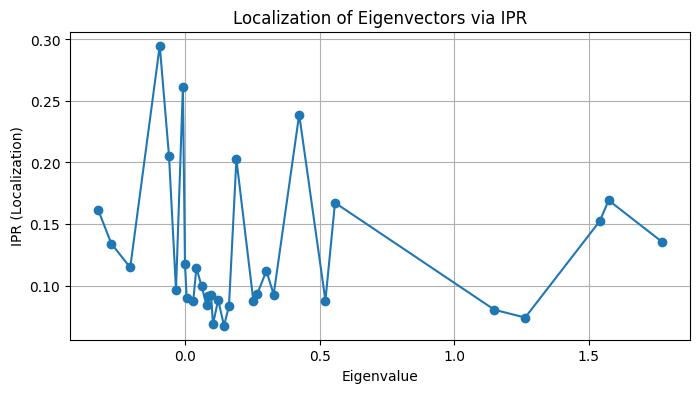

In [197]:
def compute_ipr(eigenvectors):
    """
    Compute Inverse Participation Ratio (IPR) for each eigenvector.
    Parameters:
        eigenvectors (np.ndarray): Matrix with eigenvectors as columns.
    Returns:
        list: IPR values.
    """
    ipr = []
    for v in eigenvectors.T:  # eigenvectors are columns
        norm_v = v / np.linalg.norm(v)
        ipr_val = np.sum(np.abs(norm_v)**4)
        ipr.append(ipr_val)
    return np.array(ipr)

# Example: Random symmetric matrix (can replace with your banded matrix)


# Eigen decomposition
eigvals, eigvecs = np.linalg.eigh(filtered_matrix)

# Compute IPR
ipr_values = compute_ipr(eigvecs)

# Plot IPR
plt.figure(figsize=(8, 4))
plt.plot(eigvals, ipr_values, 'o-')
plt.xlabel('Eigenvalue')
plt.ylabel('IPR (Localization)')
plt.title('Localization of Eigenvectors via IPR')
plt.grid(True)
plt.show()

Ansatz selection is from realamplitude because the matrix is real and the eigenvectors will be real, this is a simple ansatz in this regard.

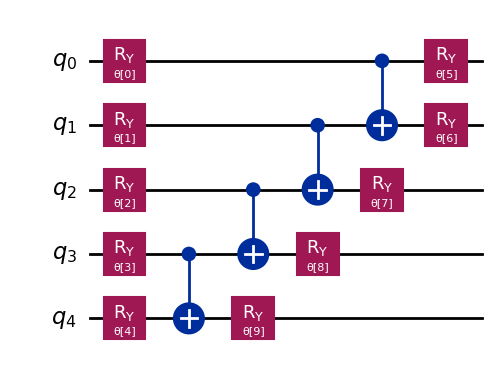

In [198]:
from qiskit.circuit.library import real_amplitudes
qc=QuantumCircuit(qubits)
# for i in range(qubits):
#     qc.h(i)
ansatz=real_amplitudes(num_qubits=qubits,reps=1)
qc=qc.compose(ansatz)
qc.draw("mpl")

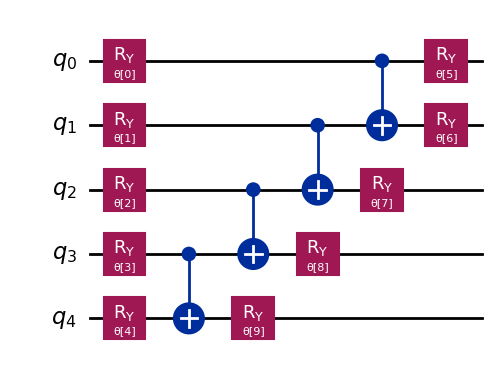

In [199]:
qc2=QuantumCircuit(qubits)
qc2=qc2.compose(ansatz)
qc2.draw("mpl")

Using SparsePauli VQE without enforcing band structure, what excited-state energy is obtained from the full Hamiltonian?

In [200]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize
def objfun(params,circuit,hamiltonian):
    estimator=StatevectorEstimator()
    job=estimator.run([(circuit,hamiltonian,[params])])
    return job.result()[0].data.evs
params=np.random.randn(qc.num_parameters)
z=minimize(objfun,params,args=(qc,-pauli_op),method="SLSQP",options={'maxiter':20, 'ftol':1e-6})
print(z)

 message: Iteration limit reached
 success: False
  status: 9
     fun: -1.8269281219091755
       x: [ 2.799e-01 -2.921e+00  5.649e-02 -4.832e+00  1.546e+00
            1.848e+00 -1.293e+00 -5.970e-01  1.599e+00  1.590e+00]
     nit: 20
     jac: [ 1.996e-04  1.370e-03 -7.029e-04 -8.653e-05  6.265e-04
           -1.614e-04  2.767e-04 -4.930e-04  8.617e-04 -1.105e-03]
    nfev: 221
    njev: 20


Difference if we use trained initialization based on the prior knowledge that the eigen state is delocalized

In [201]:
from qiskit.quantum_info import Statevector
import numpy as np

def sample_params_for_ipr(circuit, ipr_low=0.1, ipr_high=0.3, max_trials=500):
    n_params = circuit.num_parameters
    for trial in range(max_trials):
        trial_params = np.random.randn(n_params)
        sv = Statevector(circuit.assign_parameters(trial_params)).data
        ipr = np.sum(np.abs(sv) ** 4)
        if ipr_low <= ipr <= ipr_high:
            print(f"✓ Found IPR = {ipr:.3f} on trial {trial}")
            return trial_params
    raise ValueError(f"Failed to find IPR ∈ [{ipr_low}, {ipr_high}] in {max_trials} trials.")
t_params=sample_params_for_ipr(qc2, ipr_low=0.2, ipr_high=0.4, max_trials=500)
z_pure=minimize(objfun,t_params,args=(qc2,-pauli_op),method="SLSQP",options={'maxiter':20, 'ftol':1e-6})
print(z_pure)

✓ Found IPR = 0.258 on trial 7
 message: Iteration limit reached
 success: False
  status: 9
     fun: -2.008813109186592
       x: [-3.038e-01 -2.418e+00  1.985e-02  5.528e-02  2.595e+00
            1.507e+00 -1.375e+00 -1.889e+00  1.492e-01  5.330e-01]
     nit: 20
     jac: [-2.021e-05  5.823e-05  4.431e-04  1.039e-04  6.050e-06
           -1.244e-04 -1.376e-04 -2.481e-04 -3.872e-04 -6.303e-05]
    nfev: 224
    njev: 20


For the banded, locally correlated Hamiltonian, we construct a filtered matrix that retains only local interaction terms. With this structured form, we aim to compute the excited-state eigenvalue, and investigate how well the variational algorithm captures delocalized excitations under this constraint.

In [208]:
z1=minimize(objfun,params,args=(qc,-filtered_op),method="SLSQP",options={'maxiter':30, 'ftol':1e-6})
print(z1)

 message: Iteration limit reached
 success: False
  status: 9
     fun: -1.6960374541839158
       x: [ 1.044e-01 -5.062e-01 -2.638e-01  9.169e-01  1.664e+00
            1.685e+00  1.594e+00  1.895e+00 -2.006e-01  1.476e+00]
     nit: 30
     jac: [ 7.701e-03  8.111e-03  3.249e-02  1.226e-03  3.305e-03
            3.011e-03  1.654e-03  7.749e-03 -1.676e-03 -3.539e-03]
    nfev: 332
    njev: 30


Comparison of Measurement Cost via Pauli Grouping:
We analyze the reduction in the number of measurements achieved through Pauli grouping. This is done by comparing the original (exact) set of Pauli terms with a filtered subset that retains only local interactions. The filtered Hamiltonian exhibits more structured and localized correlations, enabling a more compressed representation through commutation-based grouping.

In [203]:


# Full operator (no filtering)
collection_full = ObservableCollection(pauli_op.paulis)


collection_filtered = ObservableCollection(filtered_op.paulis)

# Stats
n_full_terms = len(pauli_op)
n_filtered_terms = len(filtered_op)
n_full_groups = len(collection_full.groups)
n_filtered_groups = len(collection_filtered.groups)

# Grouping Advantage Ratio (GAR)
gar_full = n_full_terms / n_full_groups
gar_filtered = n_filtered_terms / n_filtered_groups

# Print Results
print("=== Grouping Comparison ===")
print(f"Total Pauli terms (full):       {n_full_terms}")
print(f"Commuting groups (full):        {n_full_groups}")
print(f"Grouping Advantage Ratio (full):   {gar_full:.2f}\n")

print(f"Total Pauli terms (filtered):   {n_filtered_terms}")
print(f"Commuting groups (filtered):    {n_filtered_groups}")
print(f"Grouping Advantage Ratio (filtered): {gar_filtered:.2f}")


=== Grouping Comparison ===
Total Pauli terms (full):       528
Commuting groups (full):        122
Grouping Advantage Ratio (full):   4.33

Total Pauli terms (filtered):   236
Commuting groups (filtered):    41
Grouping Advantage Ratio (filtered): 5.76


Our Next target is to explore the localization effect of the eigenvectors in such scenarios and blend this into VQE cost function.

In [204]:
def objfun_ipr_range(params, circuit, hamiltonian, ipr_low=1/4, ipr_high=1/3, weight=50.0):
    # Energy via estimator
    estimator = StatevectorEstimator()
    job = estimator.run([(circuit, hamiltonian, [params])])
    energy = job.result()[0].data.evs

    # Get statevector
    psi = circuit.assign_parameters(params)
    sv = Statevector(psi).data
    ipr = np.sum(np.abs(sv)**4)

    # Penalty: only if ipr is out of range
    if ipr < ipr_low:
        penalty = weight * (ipr - ipr_low)**2
    elif ipr > ipr_high:
        penalty = weight * (ipr - ipr_high)**2
    else:
        penalty = 0.0

    return energy + penalty


In [205]:
params = np.random.randn(qc.num_parameters)
result_ipr = minimize(
    objfun_ipr_range,
    params,
    args=(qc, -filtered_op, 1/5, 1/3, 50.0),
    method="BFGS"
)
print(result_ipr)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.6686261221614085
        x: [ 1.403e-01 -9.978e-01 -7.137e-01  1.295e+00  1.574e+00
             1.708e+00  1.140e+00  2.401e+00 -1.122e+00  1.560e+00]
      nit: 61
      jac: [ 4.470e-08 -3.695e-06  7.302e-07  2.638e-06 -8.941e-08
             5.662e-07 -3.725e-07 -2.339e-06  3.234e-06  1.937e-07]
 hess_inv: [[ 2.983e+00  3.280e+00 ...  9.505e-01  6.569e-02]
            [ 3.280e+00  1.744e+01 ...  3.422e+00 -2.370e-01]
            ...
            [ 9.505e-01  3.422e+00 ...  4.144e+00  1.341e-01]
            [ 6.569e-02 -2.370e-01 ...  1.341e-01  2.133e+00]]
     nfev: 748
     njev: 68


In [206]:
def energy_obj(x, circuit, hamiltonian):
    # returns ⟨ψ(x)|H|ψ(x)⟩
    est=StatevectorEstimator()
    res = est.run([(circuit, hamiltonian, [x])]).result()
    return res[0].data.evs

def participation_minus_lower(x, circuit, lower=3.0):
    sv  = Statevector(circuit.assign_parameters(x)).data
    P   = 1.0/np.sum(np.abs(sv)**4)
    return P - lower      # ≥ 0

def upper_minus_participation(x, circuit, upper=4.0):
    sv  = Statevector(circuit.assign_parameters(x)).data
    P   = 1.0/np.sum(np.abs(sv)**4)
    return upper - P      # ≥ 0

# your already‑built, hardware‑friendly circuit:

# initial guess (we sampled or zeroed it so already P∈[3,4])
x0 = t_params

cons = [
  {'type':'ineq', 'fun': participation_minus_lower, 'args':(qc,1.0)},
  {'type':'ineq', 'fun': upper_minus_participation, 'args':(qc,3.0)}
]

res = minimize(
    energy_obj,
    x0,
    args=(qc, -pauli_op),
    method='SLSQP',        # or 'trust-constr'
    constraints=cons,
    options={'maxiter':30, 'ftol':1e-6}
)

print(f"done: energy={res.fun:.6f}, P={1/np.sum(np.abs(Statevector(qc.assign_parameters(res.x)).data)**4):.3f}")
print(res)


done: energy=-1.503491, P=3.000
 message: Iteration limit reached
 success: False
  status: 9
     fun: -1.5034912460005427
       x: [ 5.180e-01 -2.867e+00  1.319e+00  1.233e+00  1.537e+00
            1.593e+00 -1.254e+00  1.017e+00 -1.456e+00 -1.526e+00]
     nit: 30
     jac: [ 1.269e-01  1.470e-01 -8.292e-02  8.645e-02  1.206e-02
           -1.332e-01  1.117e-01  8.343e-02 -1.967e-03  5.337e-03]
    nfev: 341
    njev: 30
